# Imports #

In [1]:
import numpy as np 
import pandas as pd 
import os
import pywt
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, roc_auc_score

from itertools import cycle

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Softmax, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

# Import the data #

In [2]:
path = r'C:\Users\dajka\Documents\Egyetem\MSC\I\CP\Project_1\mitbih_database/'

In [3]:
filenames = next(os.walk(path))[2]

data = list()
annotations = list()
filenames.sort()

In [4]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if(file_extension == '.csv'):
        data.append(path + filename + file_extension)
    else:
        annotations.append(path + filename + file_extension)

In [5]:
# Reading the signals into one dataframe
signal_list = []
for r in range(0,48):
    with open(data[r], 'rt') as file:
        df = pd.read_csv(file, sep=',')
        signal = df.T.iloc[1:2].reset_index(drop=True)
        signal_list.append(signal)
        
signals = pd.concat(signal_list)
signals = signals.reset_index(drop=True)

In [6]:
# Different type of heartbeats
classes = ['N', 'L', 'R', 'A', 'V']
random_state = 42

In [7]:
signals.head()

,0,1,2,3,4,5,6,7,8,9,...,649990,649991,649992,649993,649994,649995,649996,649997,649998,649999
0,995,995,995,995,995,995,995,995,1000,997,...,1189,1208,1203,1168,1099,1009,935,889,871,768
1,955,955,955,955,955,955,955,955,958,960,...,964,965,967,968,967,966,965,965,966,1024
2,984,984,984,984,984,984,984,984,986,989,...,999,995,993,993,993,992,992,990,985,1024
3,949,949,949,949,949,949,949,949,947,947,...,1005,999,994,991,990,984,979,977,975,1024
4,994,994,994,994,994,994,994,994,995,997,...,1006,1006,1007,1007,1007,1010,1010,1011,1012,1024


Read the annotation files and assing beat types to the corresponding signal:

In [8]:
beat=[]
peak=[]
beat_type=[]
for k in range(0,48):
    df = pd.read_csv(annotations[k], sep='\s+',engine='python')
    ndf = df.iloc[:,1:3]
    signal = signals[k*1:(k*1)+1].values[0]
    for d in range(0, len(ndf)):
        if(ndf['#'][d] in classes):
            if ndf['Sample'][d]-150 > 0 and ndf['Sample'][d] + 150 < len(signal):
                beat.append(signal[ndf['Sample'][d]-150:ndf['Sample'][d]+150])
                peak.append(ndf['Sample'][d])
                beat_type.append(ndf['#'][d])

In [9]:
dataframe = pd.DataFrame(beat)

In [10]:
dataframe['type'] = beat_type

# Preprocessing

Different types of heartbest:

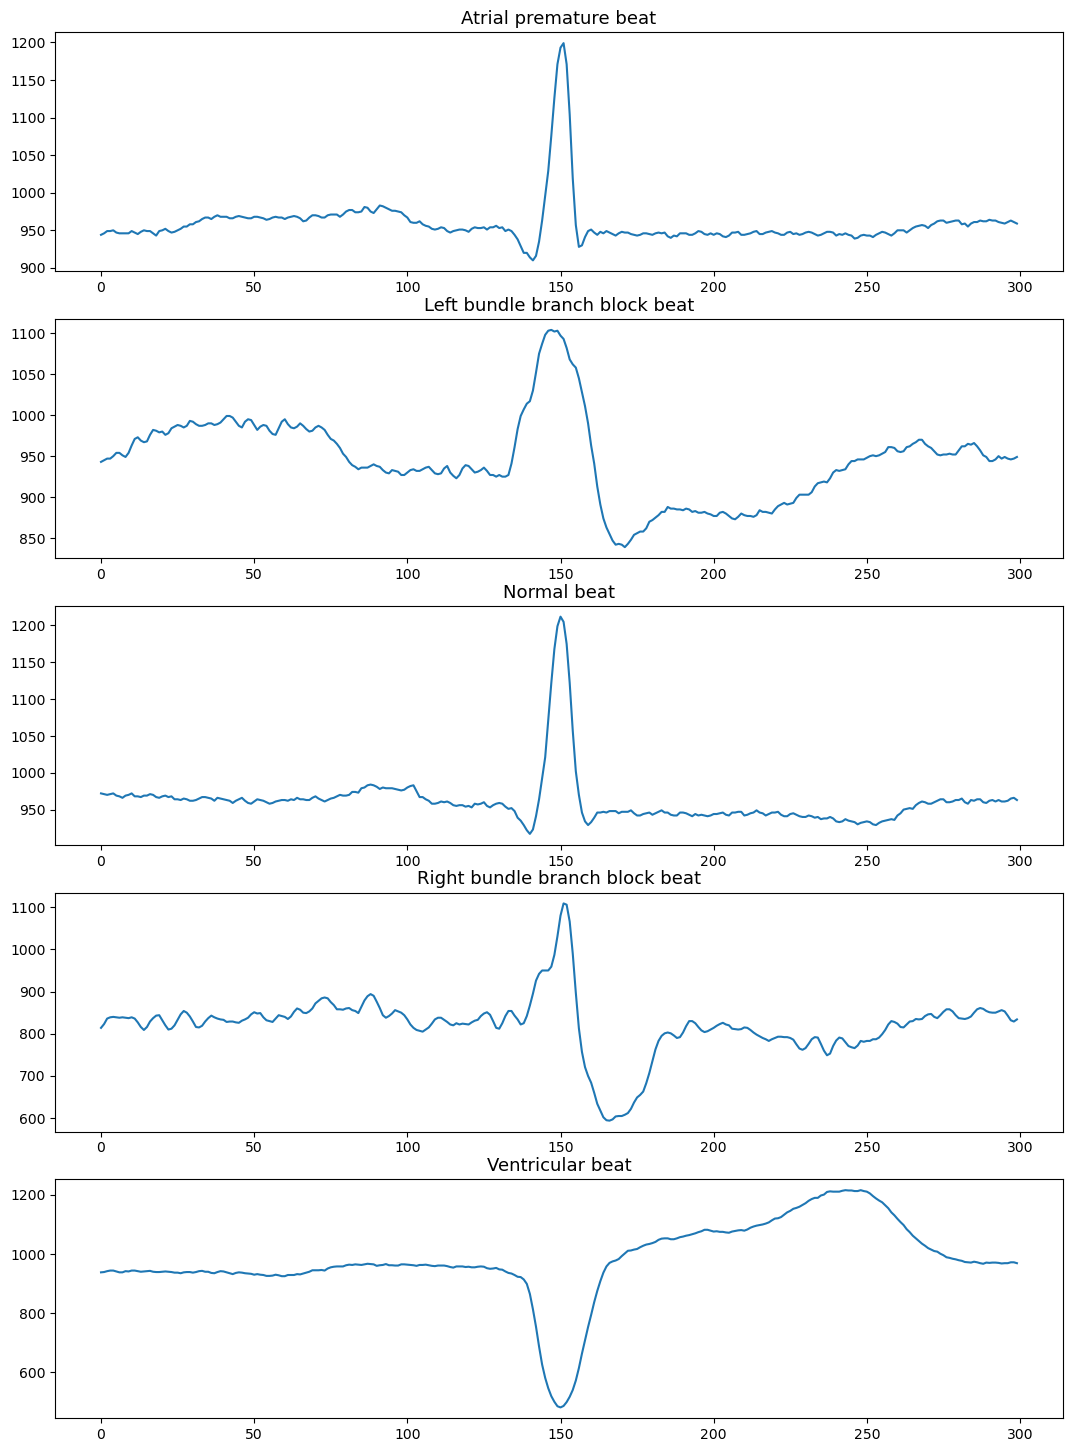

In [11]:
fig, axs = plt.subplots(5, 1, figsize=[13,18])
axs[0].plot(dataframe[dataframe['type']=='A'].iloc[:,:-1].values[0])
axs[0].set_title('Atrial premature beat',fontsize=13)
axs[1].plot(dataframe[dataframe['type']=='L'].iloc[:,:-1].values[0])
axs[1].set_title('Left bundle branch block beat',fontsize=13)
axs[2].plot(dataframe[dataframe['type']=='N'].iloc[:,:-1].values[0])
axs[2].set_title('Normal beat',fontsize=13)
axs[3].plot(dataframe[dataframe['type']=='R'].iloc[:,:-1].values[0])
axs[3].set_title('Right bundle branch block beat',fontsize=13)
axs[4].plot(dataframe[dataframe['type']=='V'].iloc[:,:-1].values[0])
axs[4].set_title('Ventricular beat',fontsize=13)
plt.savefig('beats.png')
plt.show()

Initial distribution of heartbeat types:

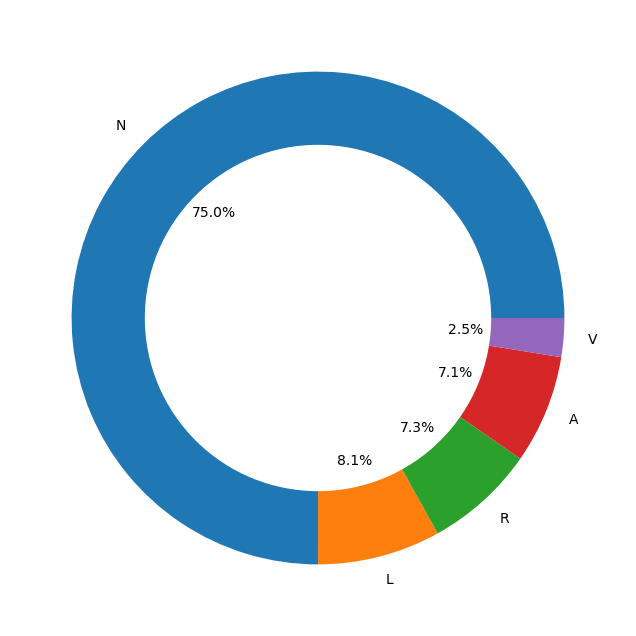

In [12]:
plt.figure(figsize=(10,8))
circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(dataframe['type'].value_counts(), labels=['N', 'L', 'R', 'A', 'V'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig("pie")
plt.show()

In order to train the model properly, the beat distribution need to more equal. One method of achieving that is downsampling the bigger datasets.

In [13]:
# Resampling the dataset
N_re = (dataframe[dataframe['type']=='N']).sample(n=2500, random_state=random_state)
L_re = resample(dataframe[dataframe['type']=='L'], replace=True, n_samples=2500, random_state=random_state)
R_re = resample(dataframe[dataframe['type']=='R'], replace=True, n_samples=2500, random_state=random_state)
A_re = dataframe[dataframe['type']=='A'].iloc[:2500]
V_re = resample(dataframe[dataframe['type']=='V'], replace=True, n_samples=2500, random_state=random_state)

In [14]:
train_df = pd.concat([N_re, L_re, R_re, A_re, V_re])
train_df = shuffle(train_df)
train_df = train_df.reset_index(drop=True)

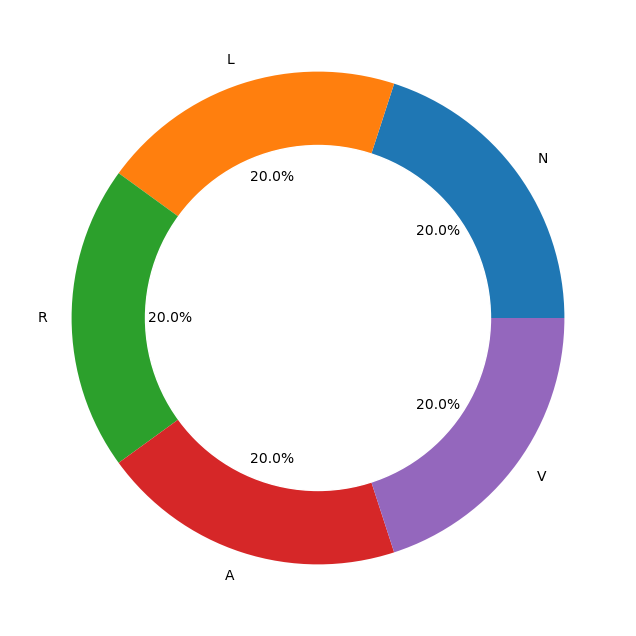

In [15]:
plt.figure(figsize=(10,8))
circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train_df['type'].value_counts(), labels=['N', 'L', 'R', 'A', 'V'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('pie_eq')
plt.show()

Now all classes have the same number of samples.

# Model 1 #

First a simple one dimensional convolution model trained on the samples.

In [16]:
y = train_df['type']
X = train_df.iloc[:,:-1]

In [17]:
X_re = X.values.reshape(X.shape[0], X.shape[1], 1)

In [18]:
X_train, X_train_test, y_train, y_train_test = train_test_split(X_re,
                               y,
                               test_size=0.20,
                               random_state=random_state)

In [19]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
encoded_train_labels = encoder.transform(y_train)
encoder.fit(y_train_test)
encoded_test_labels = encoder.transform(y_train_test)

In [20]:
y_train=to_categorical(encoded_train_labels)
y_train_test=to_categorical(encoded_test_labels)

In [21]:
X_val = X_train[:2000]
partial_X_train = X_train[2000:]
y_val = y_train[:2000]
partial_y_train = y_train[2000:]

In [25]:
model = Sequential()
model.add(Conv1D(filters=20, kernel_size=5, strides=1, padding="same", activation="relu", input_shape=(300,1)))
model.add(MaxPooling1D(1))
model.add(Conv1D(filters=20, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(1))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 300, 20)           120       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 300, 20)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 300, 20)           2020      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 300, 20)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6000)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(partial_X_train, partial_y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/20
63/63 [==============================] - 5s 67ms/step - loss: 31.4656 - accuracy: 0.2083 - val_loss: 1.0560 - val_accuracy: 0.2145
Epoch 2/20
63/63 [==============================] - 4s 60ms/step - loss: 0.7137 - accuracy: 0.3486 - val_loss: 0.4721 - val_accuracy: 0.4990
Epoch 3/20
63/63 [==============================] - 4s 60ms/step - loss: 0.4123 - accuracy: 0.5452 - val_loss: 0.3910 - val_accuracy: 0.5785
Epoch 4/20
63/63 [==============================] - 4s 60ms/step - loss: 0.3678 - accuracy: 0.6212 - val_loss: 0.3524 - val_accuracy: 0.6305
Epoch 5/20
63/63 [==============================] - 4s 60ms/step - loss: 0.3355 - accuracy: 0.6536 - val_loss: 0.3229 - val_accuracy: 0.6725
Epoch 6/20
63/63 [==============================] - 4s 60ms/step - loss: 0.3363 - accuracy: 0.6514 - val_loss: 0.3496 - val_accuracy: 0.6515
Epoch 7/20
63/63 [==============================] - 4s 62ms/step - loss: 0.3015 - accuracy: 0.6920 - val_loss: 0.3020 - val_accuracy: 0.6760
Epoch 8/20
6

In [28]:
model.evaluate(X_train_test, y_train_test)

79/79 [==============================] - 1s 6ms/step - loss: 0.1817 - accuracy: 0.8488


[0.1816505342721939, 0.848800003528595]

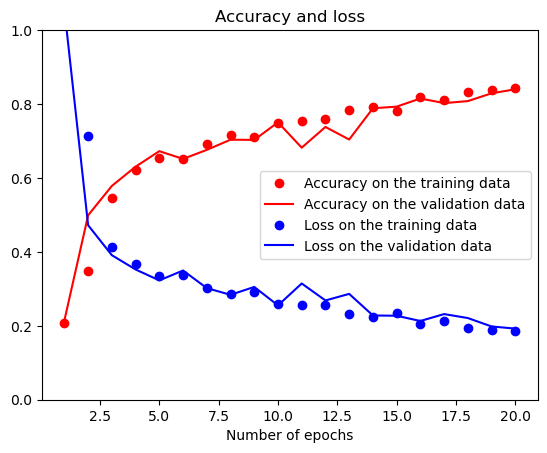

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'ro', label='Accuracy on the training data')
plt.plot(epochs, val_acc, 'r', label='Accuracy on the validation data')
plt.plot(epochs, loss, 'bo', label='Loss on the training data')
plt.plot(epochs, val_loss, 'b', label='Loss on the validation data')
plt.ylim(0,1)
plt.title('Accuracy and loss')
plt.xlabel('Number of epochs')
plt.legend()
plt.savefig("training_base_model")
plt.show()

In [30]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [31]:
y_pred = model.predict(X_train_test, batch_size=1400)

2/2 [==============================] - 0s 101ms/step


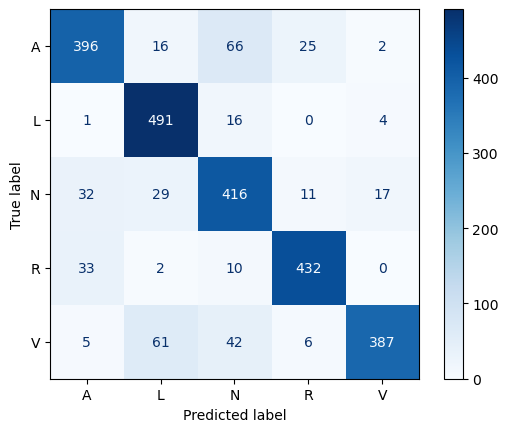

In [32]:
cm = confusion_matrix(np.argmax(y_train_test, axis=1), np.argmax(y_pred, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['A', 'L', 'N', 'R', 'V'])

disp.plot(cmap=plt.cm.Blues)
plt.savefig('basem')
plt.show()

In [33]:
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr_multi = dict()
tpr_multi = dict()
ra_scores = dict()
for i in range(n_classes):
    fpr_multi[i], tpr_multi[i], _ = roc_curve(y_train_test[:, i], y_pred[:, i])
    ra_scores[i] = roc_auc_score(y_train_test[:, i], y_pred[:, i])

Area under the ROC curve score for Atrial premature beat heartbeat detection is : 0.959610908459267
Area under the ROC curve score for Left bundle branch block beat heartbeat detection is : 0.9890927596830986
Area under the ROC curve score for Normal beat heartbeat detection is : 0.957760738479863
Area under the ROC curve score for Right bundle branch block beat heartbeat detection is : 0.9838917438969669
Area under the ROC curve score for Ventricular beat heartbeat detection is : 0.9785731188947766


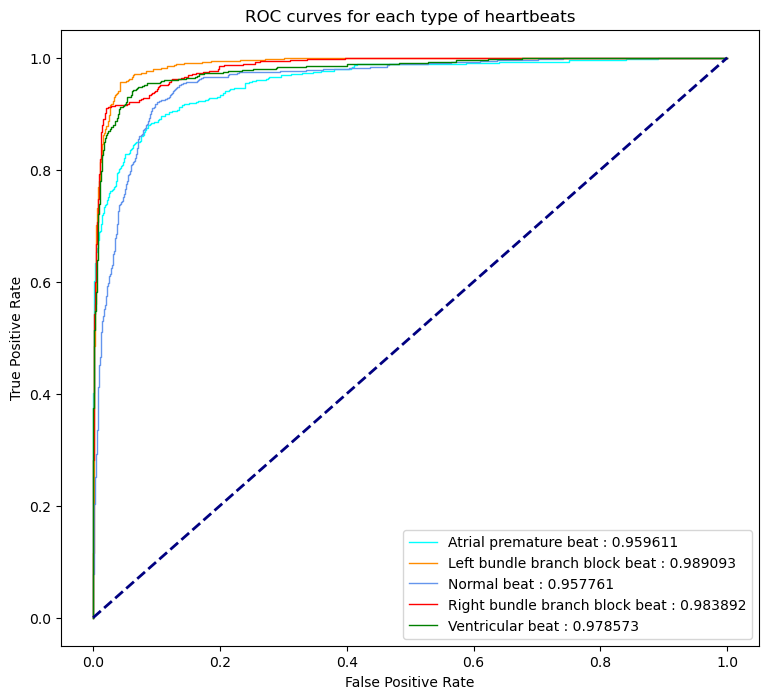

In [34]:
plt.figure(figsize=(9,8))
colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red', 'green'])
for i, color, label in zip(range(n_classes), colors, ['Atrial premature beat','Left bundle branch block beat','Normal beat','Right bundle branch block beat','Ventricular beat']):
    plt.plot(fpr_multi[i], tpr_multi[i], color=color, lw=1, label='%s : %f'%(label,ra_scores[i]))
    print('Area under the ROC curve score for', label, 'heartbeat detection is :', ra_scores[i])
    
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curves for each type of heartbeats')
plt.legend()
plt.savefig('roc')
plt.show()

# CWT #

While 1-D CNN can be used for time series signals, the flexibility of such models is limited dueto the use of 1-D kernels. On the other hand, 3-D CNNs require a large amount of training data andcomputational resources. In comparison, 2-D CNNs are more versatile since they use 2-D kernels and,hence, could provide representative features for time series data.

In [35]:
import scipy.io

In [36]:
full_df = (N_re.iloc[:,:-1].values.tolist() + L_re.iloc[:,:-1].values.tolist() + R_re.iloc[:,:-1].values.tolist() + A_re.iloc[:,:-1].values.tolist() + V_re.iloc[:,:-1].values.tolist())

Apply continous wavelet transformation:

In [37]:
fs = 100
scales = range(1, fs)
X_full = np.ndarray(shape=(len(full_df), fs-1, fs-1, 3))
                 
for i in range(0, len(full_df)):
    if i % 500 == 0:
        print (i, 'done!')
    for j in range(0, 3):
        signal = full_df[i]
        coeff, freq = pywt.cwt(signal, scales, 'morl', 1)
        X_full[i, :, :, j] = coeff[:,:fs-1]

0 done!
500 done!
1000 done!
1500 done!
2000 done!
2500 done!
3000 done!
3500 done!
4000 done!
4500 done!
5000 done!
5500 done!
6000 done!
6500 done!
7000 done!
7500 done!
8000 done!
8500 done!
9000 done!
9500 done!
10000 done!
10500 done!
11000 done!
11500 done!
12000 done!


Plot tranfsormed images:

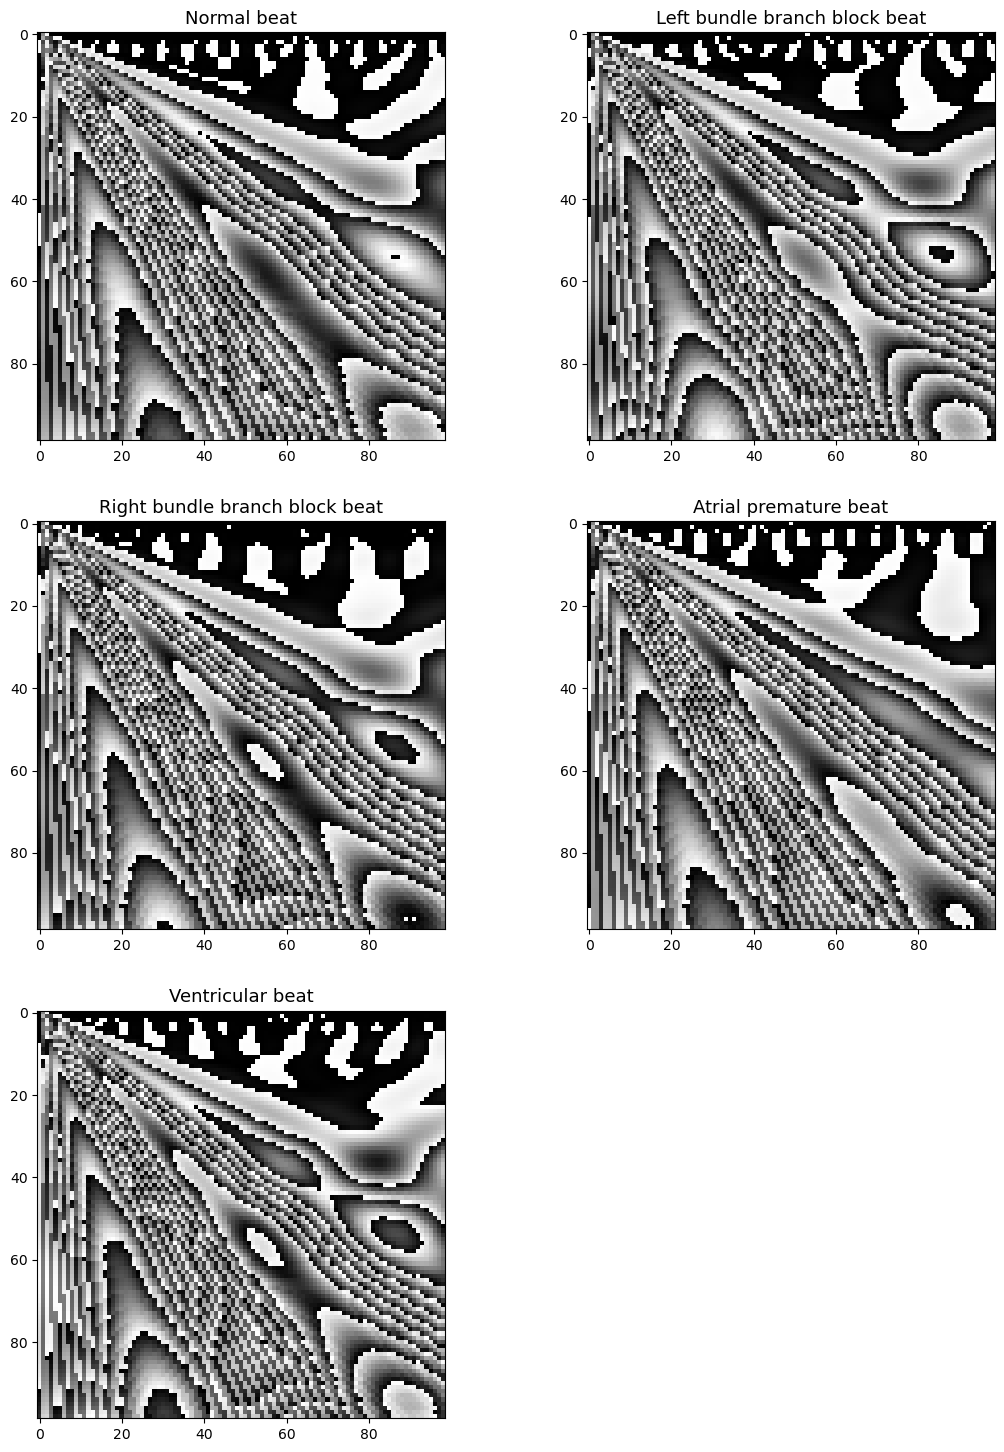

In [38]:
fig, axs = plt.subplots(3, 2, figsize=[13,18])
axs[0,0].imshow(abs(X_full[0].astype(np.uint8)))
axs[0,0].set_title('Normal beat',fontsize=13)
axs[0,1].imshow(abs(X_full[550].astype(np.uint8)))
axs[0,1].set_title('Left bundle branch block beat',fontsize=13)
axs[1,0].imshow(abs(X_full[1050].astype(np.uint8)))
axs[1,0].set_title('Right bundle branch block beat',fontsize=13)
axs[1,1].imshow(abs(X_full[1550].astype(np.uint8)))
axs[1,1].set_title('Atrial premature beat',fontsize=13)
axs[2,0].imshow(abs(X_full[2050].astype(np.uint8)))
axs[2,0].set_title('Ventricular beat',fontsize=13)
fig.delaxes(axs[2,1])
plt.savefig("scaleogram")
plt.show()

In [39]:
# Make labels
list_ecg_labels_n = ['N']*2500 
list_ecg_labels_l = ['L']*2500
list_ecg_labels_r = ['R']*2500 
list_ecg_labels_a = ['A']*2500 
list_ecg_labels_v = ['V']*2500 
list_ecg_labels = (list_ecg_labels_n + list_ecg_labels_l + list_ecg_labels_r + list_ecg_labels_a + list_ecg_labels_v)

le = preprocessing.LabelEncoder()
ecg_labels_encoded = le.fit_transform(list_ecg_labels)
X_train, X_test, y_train, y_test = train_test_split(X_full, ecg_labels_encoded, test_size=0.25, random_state=42)

In [40]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History 
history = History()

In [41]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

input_shape = X_train[0].shape
batch_size = 64
loss_function = sparse_categorical_crossentropy
no_classes = 5
no_epochs = 7
optimizer = Adam()
validation_split = 0.3
verbosity = 1

In [42]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.L2(0.000001)))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [43]:
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 97, 97, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 33856)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [47]:
history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Epoch 1/7
103/103 [==============================] - 180s 2s/step - loss: 42.6478 - accuracy: 0.6152 - val_loss: 0.4286 - val_accuracy: 0.8610
Epoch 2/7
103/103 [==============================] - 199s 2s/step - loss: 0.4040 - accuracy: 0.8734 - val_loss: 0.3063 - val_accuracy: 0.9054
Epoch 3/7
103/103 [==============================] - 177s 2s/step - loss: 0.2395 - accuracy: 0.9238 - val_loss: 0.2401 - val_accuracy: 0.9189
Epoch 4/7
103/103 [==============================] - 174s 2s/step - loss: 0.1733 - accuracy: 0.9453 - val_loss: 0.2396 - val_accuracy: 0.9246
Epoch 5/7
103/103 [==============================] - 176s 2s/step - loss: 0.1323 - accuracy: 0.9590 - val_loss: 0.2196 - val_accuracy: 0.9346
Epoch 6/7
103/103 [==============================] - 172s 2s/step - loss: 0.1124 - accuracy: 0.9637 - val_loss: 0.2326 - val_accuracy: 0.9225
Epoch 7/7
103/103 [==============================] - 181s 2s/step - loss: 0.0994 - accuracy: 0.9653 - val_loss: 0.2092 - val_accuracy: 0.9392


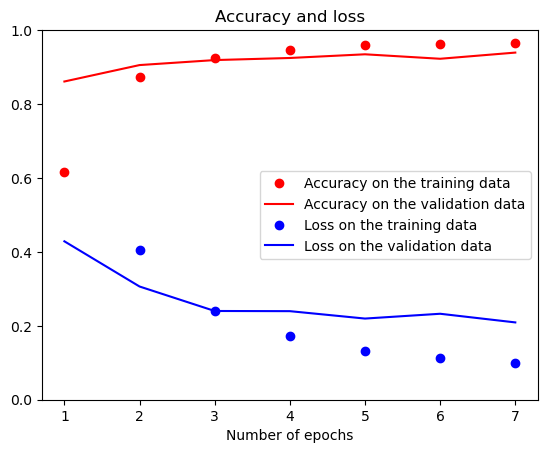

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'ro', label='Accuracy on the training data')
plt.plot(epochs, val_acc, 'r', label='Accuracy on the validation data')
plt.plot(epochs, loss, 'bo', label='Loss on the training data')
plt.plot(epochs, val_loss, 'b', label='Loss on the validation data')
plt.ylim(0,1)
plt.title('Accuracy and loss')
plt.xlabel('Number of epochs')
plt.legend()
plt.savefig("training_base_model")
plt.show()

In [49]:
model.evaluate(X_test, y_test)

98/98 [==============================] - 20s 200ms/step - loss: 0.1991 - accuracy: 0.9469


[0.1990516632795334, 0.9468799829483032]

In [50]:
y_pred = model.predict(X_test)

98/98 [==============================] - 20s 207ms/step


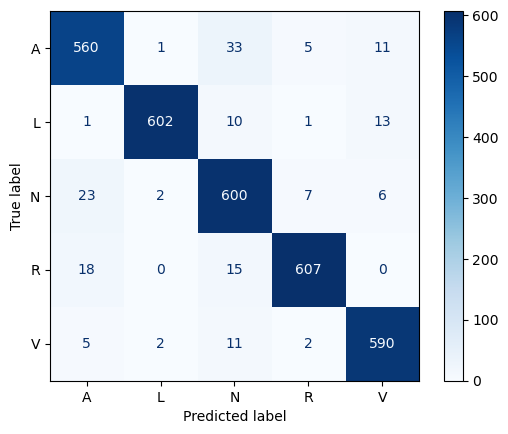

In [51]:
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['A', 'L', 'N', 'R', 'V'])

disp.plot(cmap=plt.cm.Blues)
plt.savefig('cwtm')
plt.show()

In [52]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y_test)

encoded_test_labels = encoder.transform(y_test)
y_try_test = to_categorical(encoded_test_labels)

In [53]:
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr_multi = dict()
tpr_multi = dict()
ra_scores = dict()
for i in range(n_classes):
    fpr_multi[i], tpr_multi[i], _ = roc_curve(y_try_test[:, i], y_pred[:, i])
    ra_scores[i] = roc_auc_score(y_try_test[:, i], y_pred[:, i])

Area under the ROC curve score for Atrial premature beat heartbeat detection is : 0.9856780627709155
Area under the ROC curve score for Left bundle branch block beat heartbeat detection is : 0.9987875467838386
Area under the ROC curve score for Normal beat heartbeat detection is : 0.9909762741175743
Area under the ROC curve score for Right bundle branch block beat heartbeat detection is : 0.9982507545271629
Area under the ROC curve score for Ventricular beat heartbeat detection is : 0.9965606361829026


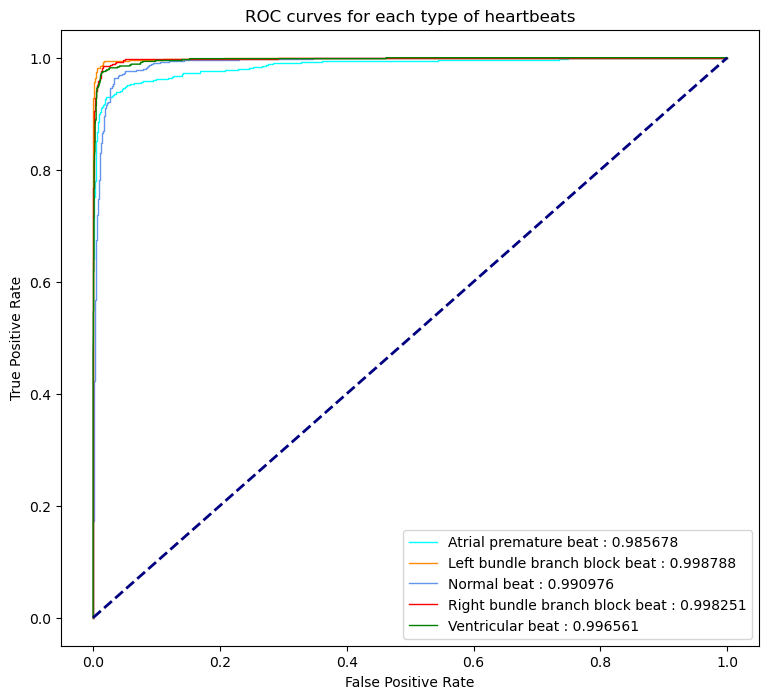

In [54]:
plt.figure(figsize=(9,8))
colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red', 'green'])
for i, color, label in zip(range(n_classes), colors, ['Atrial premature beat','Left bundle branch block beat','Normal beat','Right bundle branch block beat','Ventricular beat']):
    plt.plot(fpr_multi[i], tpr_multi[i], color=color, lw=1, label='%s : %f'%(label,ra_scores[i]))
    print('Area under the ROC curve score for', label, 'heartbeat detection is :', ra_scores[i])
    
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curves for each type of heartbeats')
plt.legend()
plt.savefig('roc_2')
plt.show()